<h1>Zero Shot Referring with Natural Language</h1>
This project uses a pipeline architecture and it is broken down into 3 primary modules: <b>NLP, Image Processing</b> and <b>Visual Grounding</b> modules.

To run the project, 2 inputs are required: an image, and a natural language sentence that describes the region in the image to be highlighted. These inputs would be passed to the individual modules, and the output of each module would be passed to the next relevant module. Once all processing is done, a final output highlighting the region of interest would be displayed to the user.

<h2>1. NLP Module</h2>
The NLP module oversees the processing of sentence input from the user and passing it as a readable format to other modules. The python library utilized for this module is Natural Language Toolkit (NLTK), and it can perform noun and adjective extraction in a phrase or sentence through its Part-Of-Speech (POS) tagging functions.

Adjectives that can be processed are first defined in the keywords list. The process_noun_adj function will take in the user input and output a noun_list and adj_list, with the elements corresponding to each other. For example, the adjective corresponding to noun_list element 1 can be found in adj_list element 1.

The adj_list will be passed to the visual grounding module, while the noun_list will be converted to a string readable by the LSeg module.

In [2]:
#user_input = "Help me segment the person in red and the left cat in this image"
#user_input = "Help me segment the right person and the left cat in this image"
#user_input = "Help me segment the cyan ball in this image"
user_input = "help me segment the person in blue in this image"
#user_input = "help me segment the cat and dog in this image"

In [3]:
#Process user input and extract nouns/adjectives
import nltk
from nltk import word_tokenize
#nltk.download('universal_tagset')
#Keywords to look out for as adjectives to process
dir_keywords = ["left", "right", "top", "bottom"]
color_keywords = ["red" , "green", "blue", "black", "white", "cyan", "magenta", "yellow"]
keywords = ["left", "right", "top", "bottom","red" , "green", "blue", "black", "white", "cyan", "magenta", "yellow", "segment","image"]

#For every noun in the noun list, the corresponding index in the adjacent list will have it's adjective. if no adjectives
#apply to the noun, it will be None
#Remove key words like segment and image from noun list
#2 Cases:
#1. Adjective appears before noun: eg left person or blue ball
#2. Adjective appears in the form of "Noun in Adjective": eg person in blue
def process_noun_adj(user_input):
    user_input = user_input.lower()
    tokens = word_tokenize(user_input)
    tags = nltk.pos_tag(tokens, tagset = "universal")
    print(tags)
    noun_list = []
    adj_list = []
    
    for i in range(len(tags)):
        if tags[i][1] == 'NOUN':
            if tags[i][0] not in keywords:
                noun_list.append(tags[i][0])
                #Case 1
                if i>0 and tags[i-1][1] == 'ADJ': 
                    adj_list.append(tags[i-1][0])
                #Case 2
                elif i>0 and tags[i-1][1] == 'NOUN': #For some descriptive words, it can appear as noun
                    adj_list.append(tags[i-1][0])
                else:
                    #adj_list.append(None)
                    if i+1<len(tags) and tags[i+1][0] == "in" and (tags[i+2][1] == "ADJ" or tags[i+2][1] == "NOUN"):
                        adj_list.append(tags[i+2][0])
                    else:
                        adj_list.append(None)
                        
    #necessary for lseg to filter out class
    noun_list.append("other")
    adj_list.append(None)
    return noun_list, adj_list
    
    
noun_list,adj_list = process_noun_adj(user_input)

[('help', 'VERB'), ('me', 'PRON'), ('segment', 'NOUN'), ('the', 'DET'), ('person', 'NOUN'), ('in', 'ADP'), ('blue', 'NOUN'), ('in', 'ADP'), ('this', 'DET'), ('image', 'NOUN')]


In [4]:
label_str = ""
for noun in noun_list:
    label_str += (noun+',')
label_str = label_str[:-1]
print(label_str)
print(adj_list)

person,other
['blue', None]


<h2>2. Image Processing Module</h2>
Takes in the pre-processed image and label_str (from NLP module) as input, and perform segmentation on the image based on the given classes. Outputs a singular segmentation map.


<h3> Initialize LSeg </h3>
Dataset: ade20k (default)
<br>Weights: demo_e200.ckpt (default)
<br>Backbone: clip_vitl16_384 (default)

In [5]:
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    

def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [6]:
evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()

MultiEvalModule: base_size 520, crop_size 480


LSeg_MultiEvalModule(
  (module): LSegModule(
    (train_accuracy): Accuracy()
    (val_accuracy): Accuracy()
    (net): LSegNet(
      (clip_pretrained): CLIP(
        (visual): VisionTransformer(
          (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (transformer): Transformer(
            (resblocks): Sequential(
              (0): ResidualAttentionBlock(
                (attn): MultiheadAttention(
                  (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
                )
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (mlp): Sequential(
                  (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                  (gelu): QuickGELU()
                  (c_proj): Linear(in_features=3072, out_features=768, bias=True)
                )
                (ln_2): LayerNorm((768,)

<h3>Input image and pre-processing</h3>
Perform pre-processing on input image such as converting it to a pytorch readable tensor, normalization and rearrangement of rows

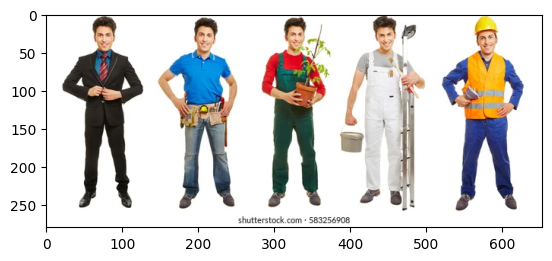

In [7]:
#img_path = 'inputs/cat2.jpeg'
#img_path = 'inputs/ADE_val_00000297.jpg'
#img_path = 'inputs/IMG_7487_smaller.jpg'
#img_path = "inputs/ball.jpg"
img_path = "inputs/outfits.jpg"
#img_path = "inputs/cats-and-dogs.jpg"


crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
plt.imshow(img)

In [8]:
#args.label_src = 'person,other'
#args.label_src = 'plant,grass,cat,stone,other'
args.label_src = label_str

In [9]:
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)

with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
#Lseg results    
predict = predicts[0]

** Input label value: person,other **
** MultiEvalModule parallel_forward phase: ['person', 'other'] **
** MultiEvalModule forward phase: ['person', 'other'] **


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


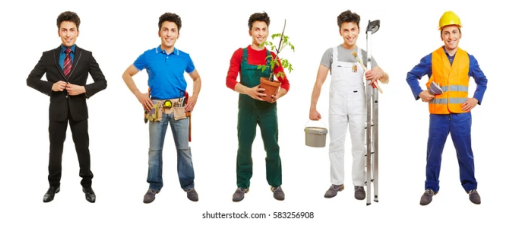

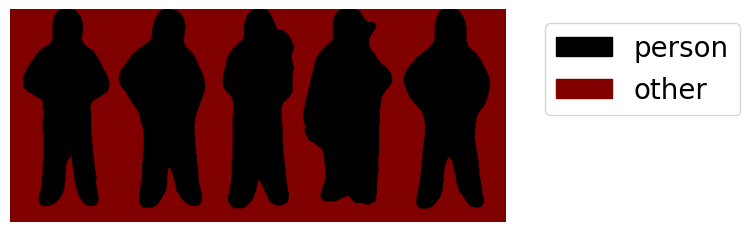

In [10]:

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
plt.axis('off')
plt.imshow(img)
plt.figure()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(seg)

<h3> Bounding Box Extraction </h3>
Extract a singular bounding box of each class from the segmentation map

In [11]:
#Draw Rectangle on input canvas
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
#Compare if pixel A and B are the same, return true if same
def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

In [12]:
#Convert the palette used in lseg into rgba for easier computation
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap
#Break the singular segmap into multiple maps for each input label, and generate a single bounding box for each label
#Each generated segmap will have transparency for pixels that are not of the label
def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)

In [13]:
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

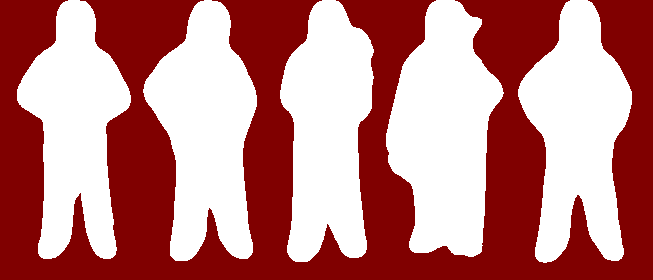

In [14]:
Image.fromarray(segmaps[1])

In [15]:
bboxes

[[17, 0, 631, 262], [0, 0, 652, 279]]

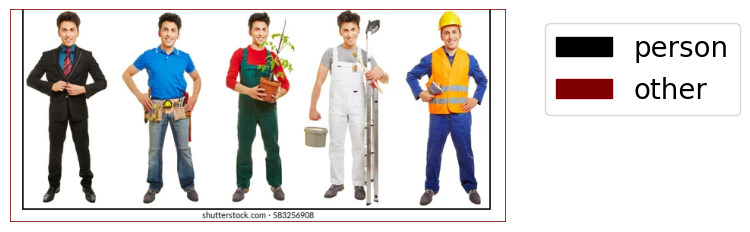

In [16]:
#Show results of bounding boxes
from PIL import Image, ImageDraw
img_copy = img.copy()
for i in range(0,len(bboxes)): #the other BBOX got bug, so minus 1
    topLeft = (bboxes[i][0],bboxes[i][1])
    bottomRight = (bboxes[i][2],bboxes[i][3])
    img1 = ImageDraw.Draw(img_copy)
    #rect_color = getHexColor(rgba_cols[i])
    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy)

<h3> Bounding Box instancing </h3>
Once the boxes have been extracted, we perform instancing by identifying contiguous rows or columns of transparent pixels within the segmentation map of a class. If there is a transparent row or column, the box can be split into 2 boxes. The scan is performed iteratively until no new boxes can be instanced.

In [17]:
#Function to find the gap within the existing bounding box
#Returns 2 arrays indicating the range or horizontal gap and vertical gap
#Values in the array can be used to identify how to split the bounding boxes
#Eg. Return value [sx1,sx2] indicates the split starts from x=sx1, y=y and ends at x=sx2, y=y

def contiguous_transparency_scan(box,segmap,instance_threshold=0):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True #whether it is a contiguous transparent block
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            #print(x)
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
        else:
            if max_x - min_x > 0:
                break
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                #isContiguous = False
                #break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
        else:
            if max_y - min_y > 0:
                break
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]


In [18]:
#Optimize the new boxes to fit nicely around the segment instance, split bounding boxes tend to be larger than segment
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#Split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox

In [19]:
#Return box size in area
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

#Return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])

In [20]:
#Main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            #x_contiguous,y_contiguous = segmap_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                instanced_boxes.pop(i) #remove the box that got split into 2 instances first
                i-=1
                for new_box in new_bboxes:
                    #append the instances only if it meets the minimum size requirement
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box)
                        new_count+=1
                #if new_count>0: #if at least one new box is added

            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances

In [21]:
w,h = img.size
min_size = w*h*0.01 #arbitary min size
new_bbox = bbox_instancing(bboxes,segmaps,min_size=min_size) 
new_bbox

[131, 142]
[-1, -1]
[257, 279]
[-1, -1]
[374, 385]
[-1, -1]
[504, 517]
[-1, -1]
[-1, -1]
[-1, -1]


[[[17, 0, 130, 258],
  [143, 0, 256, 260],
  [280, 0, 373, 259],
  [386, 0, 503, 256],
  [518, 0, 627, 258]],
 [[0, 0, 652, 279]]]

In [22]:
#****NOT IN USE****
#But in order for this idea to work, a concavity must exist in the graph, else it will keep taking the edges of the segmap
def get_local_min_range(seg_list, instance_threshold):
    seg_len = len(seg_list)
    if seg_len<=5:
        return [-1,-1]
    trimming = int(seg_len*0.05)
    min_val = 99999
    min_idx = 0
    ret_val = [0,0]
    for i in range(trimming, seg_len-trimming):
        if seg_list[i]<min_val:
            min_val = seg_list[i]
            min_idx = i
        
        #print(min_idx)
       # print(seg_len)
        if min_val == 0:
            ret_val[0]=min_idx
            cur = seg_list[min_idx]
            while(cur==0 and min_idx<seg_len-1):
                cur = seg_list[min_idx]
                min_idx+=1
            ret_val[1] = min_idx
        else:
            ret_val = [min_idx-1,min_idx+1]
    return ret_val
            
#a 2nd level instancing method
def local_min_instancing(box,segmap,instance_threshold=5):
    seg_list = []
    for x in range(box[0],box[2]):
        y_count = 0
        for y in range(box[1],box[3]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                y_count+=1
        seg_list.append(y_count)
    x_contiguous = get_local_min_range(seg_list,instance_threshold)
    x_contiguous = [x+box[0] for x in x_contiguous]
    
    seg_list = []
    for y in range(box[1],box[3]):
        x_count = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                x_count+=1
        seg_list.append(x_count)
    y_contiguous = get_local_min_range(seg_list, instance_threshold)
    y_contiguous = [y+box[0] for y in y_contiguous]
    return x_contiguous, y_contiguous

#current function assumes only 1 box each, now must change
def further_bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            #x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            x_contiguous,y_contiguous = local_min_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                for new_box in new_bboxes:
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box) #append the 2 instances
                        new_count+=1
                if new_count>0: #if at least one new box is added
                    instanced_boxes.pop(i) #remove the box that got split into 2 instances 
                    i-=1
            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances

#new_bbox2 = further_bbox_instancing(new_bbox,segmaps[0],min_size=50)
#new_bbox2

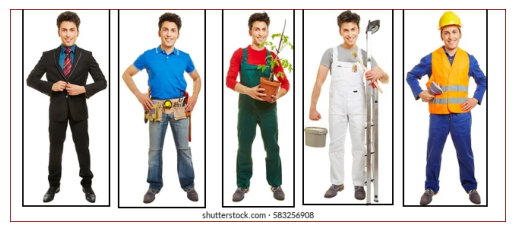

In [22]:
#sample bbox instancing result
from PIL import Image, ImageDraw
img_copy_test = img.copy()
for i in range(len(new_bbox)):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=2)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy_test)

<h2>3. Visual Grouding Module</h2>
Visual grounding module performs the filtering of bounding boxes from the image processing modules, and adjectives from the NLP module. It is able to filter colour and direction adjectives. Direction adjectives are processed by identifying the coordinates of each bounding boxes and filtering out those that do not meet the condition. 

Color adjectives are processed by finding the MSD (Mean Squared Difference) between the pixel RGB values under the segmap against the desired colour. The box with the lowest MSD will be returned.

Currently, <b>it will only return 1 box for each class.</b> Eg "Left" will return the left most bbox, and "Blue" will return the box with the lowest MSD against the blue color.

In [23]:
#Functions to process Adjectives
#Get centre of bbox
def getCentre(bbox):
    return ((bbox[2]+bbox[0])/2.0,(bbox[3]+bbox[1])/2.0)

#Filter bounding boxes based on directional keyword
#current limitation: only filters out 1 out of all the bboxes based on directional keyword
def filterBboxDirectional(bboxes, keyword = "left"):
    idx_tokeep = -1
    xmin=ymin=999999
    xmax=ymax=0
    print(keyword)
    if keyword == "left":
        for i in range(len(bboxes)):
            if getCentre(bboxes[i])[0]<xmin:
                #print(i)
                idx_tokeep = i
                xmin = getCentre(bboxes[i])[0]
    elif keyword == "right":
        for i in range(len(bboxes)):
            if getCentre(bboxes[i])[0]>xmax:
                idx_tokeep = i
                xmax = getCentre(bboxes[i])[0]
    elif keyword == "top":
        for i in range(len(bboxes)):
            if getCentre(bboxes[i])[0]<ymin:
                idx_tokeep = i
                ymin = getCentre(bboxes[i])[0]
    elif keyword == "bottom":
        for i in range(len(bboxes)):
            if getCentre(bboxes[i])[0]>ymax:
                idx_tokeep = i
                ymax = getCentre(bboxes[i])[0]
    else:
        return bboxes
    #print(idx_tokeep)
    return [bboxes[idx_tokeep]]

    

In [24]:
from matplotlib import colors as mcolors


#Mean absolute squared difference in color
#Squared difference is better because it amplifies color similarity and differences for outfits where the top can be differnet
#from the bottom
def compareColorRGB(col1,col2):
    ssd = 0
    for i in range(len(col1)):
        ssd += (abs(col1[i]-col2[i])*abs(col1[i]-col2[i]))
    
    return float(ssd)/len(col1)

#Convert color from name to rgba value
def getColorRGBA(color = "red"):
    rgba = mcolors.to_rgba(color)
    rgba_list = [ int(x * 255) for x in rgba ]
    return rgba_list

#Filter out the bboxes that do not meet the color requirement and keep one id
#Done by comparing the pixels of the image within the bounding box. Only pixels that are masked by the segmentation map
#will be processed to remove background noise in computation
def filterBboxColor(bboxes, segmap, image, color = "red"):
    if color == None:
        return bboxes
    lowest_dist = 99999
    idx_tokeep = -1
    img = image.copy()
    col_rgba = getColorRGBA (color)
    for i in range(len(bboxes)):
        numPixels = 0
        dist = 0
        for x in range(bboxes[i][0],bboxes[i][2]):
            for y in range(bboxes[i][1],bboxes[i][3]):
                #print(x,y)
                if not comparePixel(segmap[y][x],[0,0,0,0]): #only compare pixels in the original seg map
                    dist += compareColorRGB(np.asarray(image)[y][x],col_rgba)
                    numPixels+=1
        avg_dist = dist/numPixels
        print(avg_dist)
        if avg_dist<lowest_dist:
            lowest_dist = avg_dist
            idx_tokeep = i
    return [bboxes[idx_tokeep]]
                


In [25]:
processed_new_bbox = new_bbox.copy()

In [26]:
#Process the adjectives and get relevant bboxes
#For color, the larger the image, the more time taken. Tentatively use smaller images
dir_keywords = ["left", "right", "top", "bottom"]
color_keywords = ["red" , "green", "blue", "black", "white", "cyan", "magenta", "yellow"]
for i in range(len(new_bbox)):
    if adj_list[i] in dir_keywords:
        processed_new_bbox[i] = filterBboxDirectional(processed_new_bbox[i], keyword = adj_list[i])
    if adj_list[i] in color_keywords:
        processed_new_bbox[i] = filterBboxColor(processed_new_bbox[i], segmaps[i], img.copy(), color = adj_list[i])
        #processed_new_bbox[i]=[processed_new_bbox[i][2]]
processed_new_bbox

19627.63517544896
19019.537812279847
21354.31055254913
24445.939525027585
21505.928873552984


[[[143, 0, 256, 260]], [[0, 0, 652, 279]]]

Input: help me segment the person in blue in this image


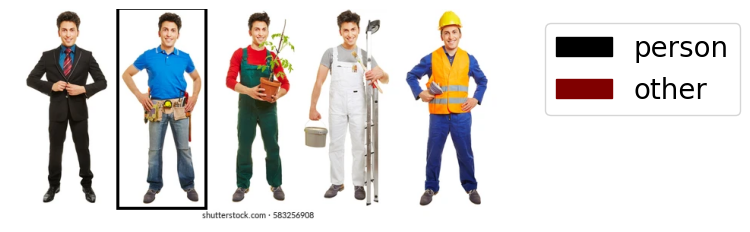

In [27]:
#sample bbox instancing result
from PIL import Image, ImageDraw
img_copy_test = img.copy()

for i in range(len(processed_new_bbox)-1): #don't display the "other" box hence -1
    for j in range(len(processed_new_bbox[i])):
        #print((processed_new_bbox[i][j]))
        topLeft = (processed_new_bbox[i][j][0],processed_new_bbox[i][j][1])
        bottomRight = (processed_new_bbox[i][j][2],processed_new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=4)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
print("Input: "+user_input)